# Analyse synthesis outputs

In [1]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt
import glob
from importlib import reload

import scatcovjax.Sphere_lib as sphlib
from scatcovjax.Scattering_lib import scat_cov_axi, scat_cov_dir
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav
import scatcovjax.plotting as plot

plot.notebook_plot_format()


# Parameters

In [35]:
reality = True
sampling = 'mw'
multiresolution = True
L = 256
N = 3
epochs = 0
J_min = 0

J = s2wav.utils.shapes.j_max(L)
print(J)

axi = False
#axi = True if N == 1 else False  # Axisym or directional

8


# Make filters

<IPython.core.display.Javascript object>


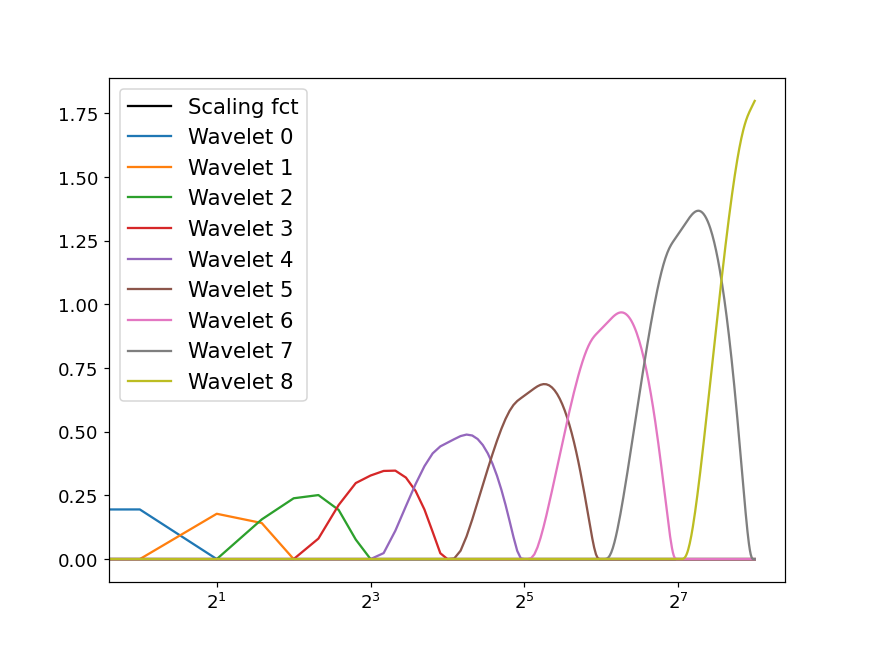

(<Figure size 800x600 with 1 Axes>, <Axes: >)

In [36]:
filters = filters_directional_vectorised(L, N, J_min)
plot.plot_filters(filters, real=True, m=L-1)

# Load the data

In [37]:
# List of job with these parameters
job_list = glob.glob(f'../scripts/outputs/*L{L}_N{N}_epochs{epochs}')
print(job_list)

# Choose the run
run = 0
output_dir = job_list[run]
print(output_dir)

# flm
flm_target = np.load(output_dir + '/flm_target.npy')
flm_start = np.load(output_dir + '/flm_start.npy')
flm_end = np.load(output_dir + '/flm_end.npy')
print(flm_end.shape)

# Loss
loss_history = np.load(output_dir + '/loss.npy')

# Coeffs
tmean, tvar, tS1, tP00, tC01, tC11 = np.load(output_dir + '/coeffs_target.npy', allow_pickle=True)
smean, svar, sS1, sP00, sC01, sC11 = np.load(output_dir + '/coeffs_start.npy', allow_pickle=True)
emean, evar, eS1, eP00, eC01, eC11 = np.load(output_dir + '/coeffs_end.npy', allow_pickle=True)

['../scripts/outputs/Job6114_L256_N3_epochs0', '../scripts/outputs/Job6112_L256_N3_epochs0']
../scripts/outputs/Job6114_L256_N3_epochs0
(256, 256)


In [38]:
tP00

Array([9.99365583e-07, 9.99365583e-07, 9.99365583e-07, 9.99365583e-07,
       9.99365583e-07, 5.50661298e-06, 4.09205644e-06, 5.89991307e-06,
       4.08481416e-06, 4.44699644e-06, 4.23054280e-05, 6.25905824e-05,
       4.97786103e-05, 4.96735349e-05, 6.25653672e-05, 5.35917575e-04,
       4.46228490e-04, 4.66416118e-04, 5.24543919e-04, 4.31157543e-04,
       1.82066076e-03, 1.90836494e-03, 1.76550665e-03, 2.07187261e-03,
       1.67536470e-03, 7.19583932e-03, 6.42498129e-03, 6.81932076e-03,
       7.02415418e-03, 6.31059592e-03, 1.92019699e-02, 1.88234622e-02,
       1.88708615e-02, 1.85031042e-02, 1.91369993e-02, 4.71797688e-02,
       4.67314080e-02, 4.65642768e-02, 4.65615316e-02, 4.75971659e-02,
       2.33783281e-02, 2.25940944e-02, 2.31497183e-02, 2.27172424e-02,
       2.28020095e-02], dtype=float64)

In [39]:
if reality:  # Get the full flm
    flm_target = sphlib.make_flm_full(flm_target, L)
    flm_start = sphlib.make_flm_full(flm_start, L)
    flm_end = sphlib.make_flm_full(flm_end, L)
print(flm_end.shape)

(256, 511)


In [40]:
# Make the maps
f_target = s2fft.inverse_jax(flm_target, L, reality=reality)
f_start = s2fft.inverse_jax(flm_start, L, reality=reality)
f_end = s2fft.inverse_jax(flm_end, L, reality=reality)

# Plots

<IPython.core.display.Javascript object>


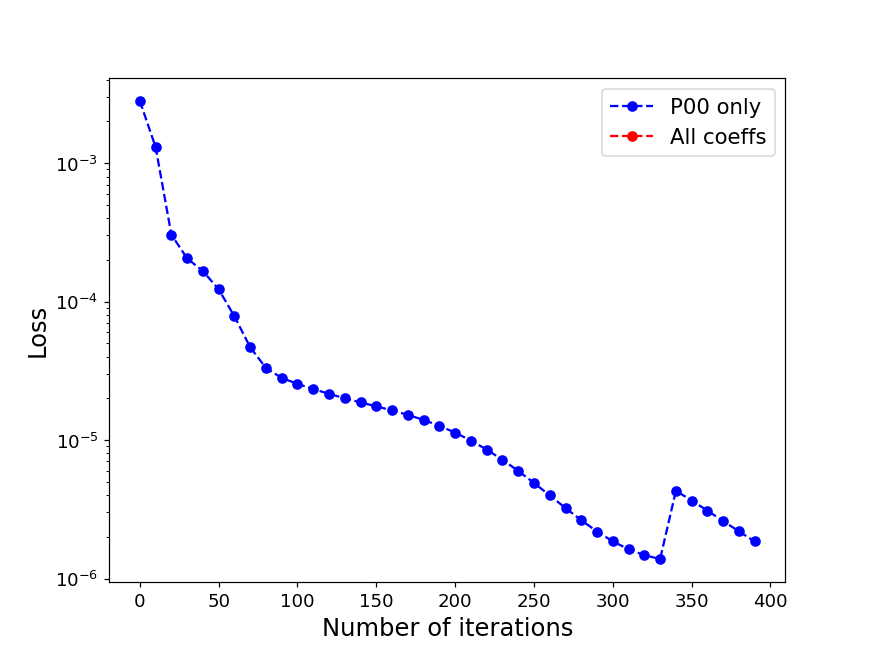

In [41]:
nit1 = 400
nit2 = 0
step = 10

plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, nit1, step), loss_history[:int(nit1/step)], 'bo--', label='P00 only')
plt.plot(np.arange(nit1, nit1 + nit2, step), loss_history[int(nit1/step):], 'ro--', label='All coeffs')
#plt.plot(loss_history, 'bo--')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')
plt.legend()

<IPython.core.display.Javascript object>


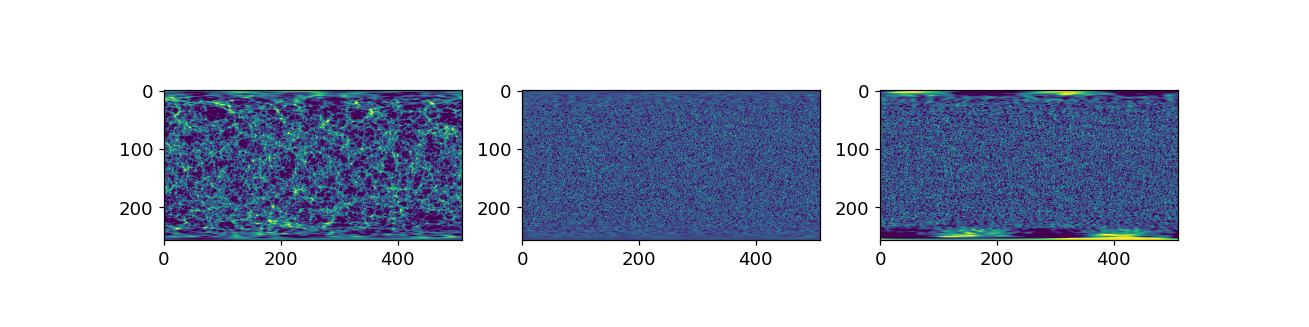

In [54]:
mx, mn = np.nanmax(f_target), np.nanmin(f_target)
mn, mx = -1, 3

fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(12,3))
ax1.imshow(f_target, vmax=mx, vmin=mn, cmap='viridis')
ax2.imshow(f_start, vmax=mx, vmin=mn, cmap='viridis')
ax3.imshow(f_end, vmax=mx, vmin=mn, cmap='viridis')
plt.show()

<IPython.core.display.Javascript object>


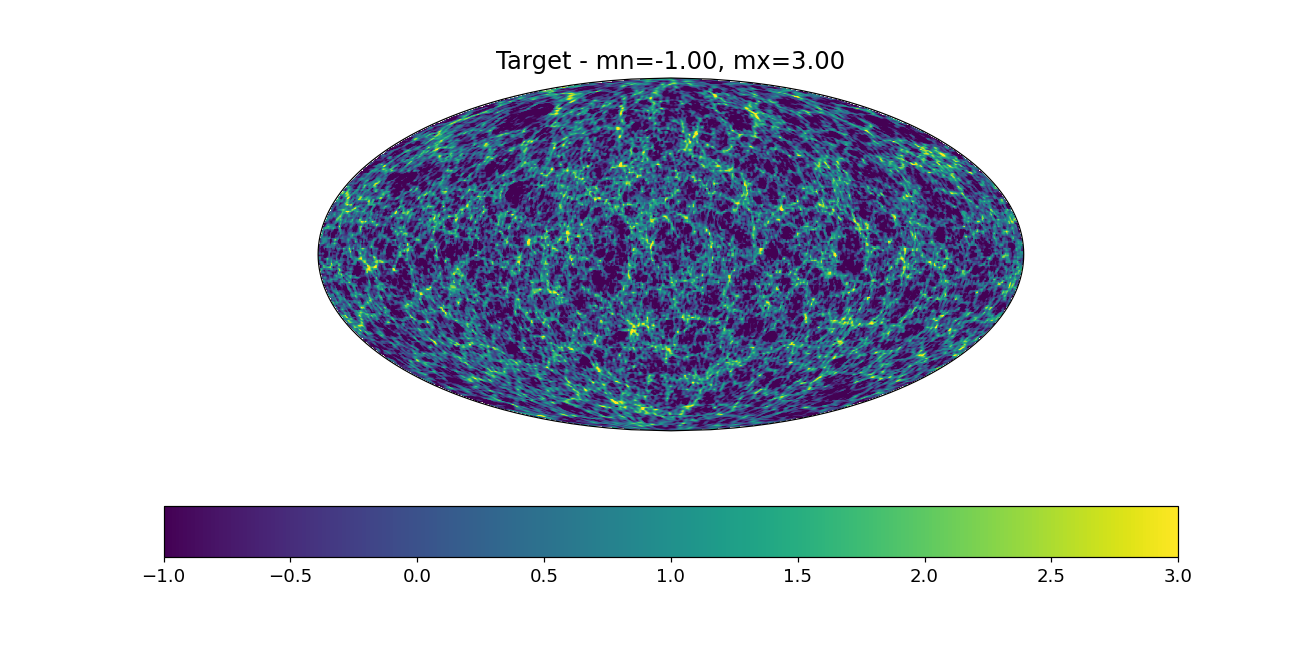

In [55]:
plot.plot_map_MW_Mollweide(f_target, vmin=mn, vmax=mx, title=f'Target - {mn=:.2f}, {mx=:.2f}', figsize=(12, 6))

<IPython.core.display.Javascript object>


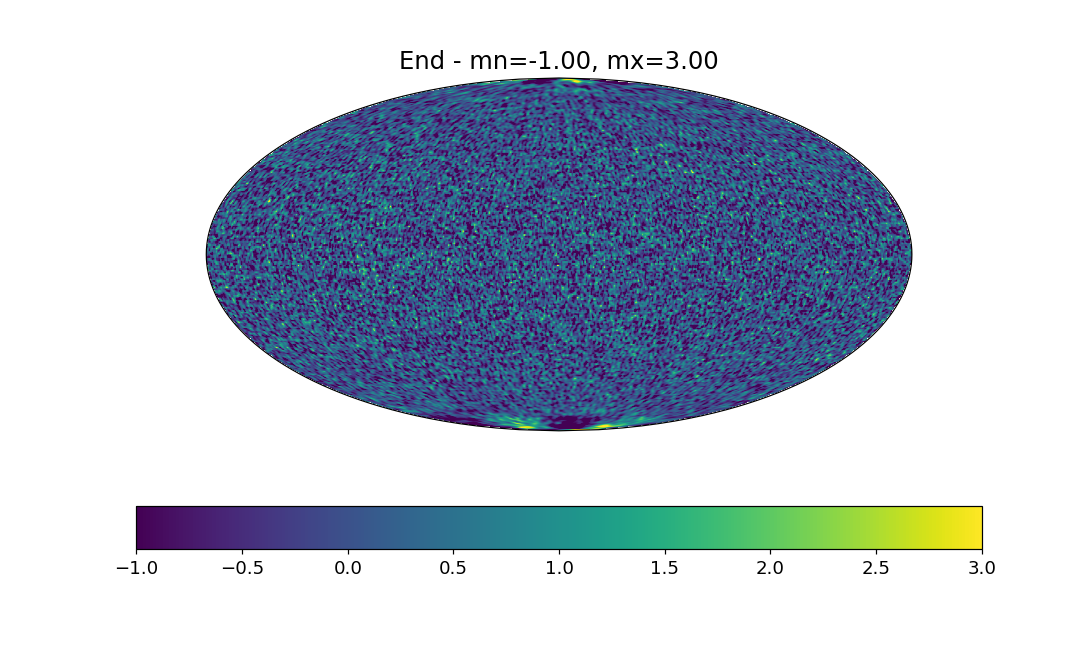

In [56]:
plot.plot_map_MW_Mollweide(f_end, vmin=mn, vmax=mx, title=f'End - {mn=:.2f}, {mx=:.2f}', figsize=(10, 6))

In [57]:
# plot.plot_sphere(f_end, L, sampling=sampling)

### Power spectrum

<IPython.core.display.Javascript object>


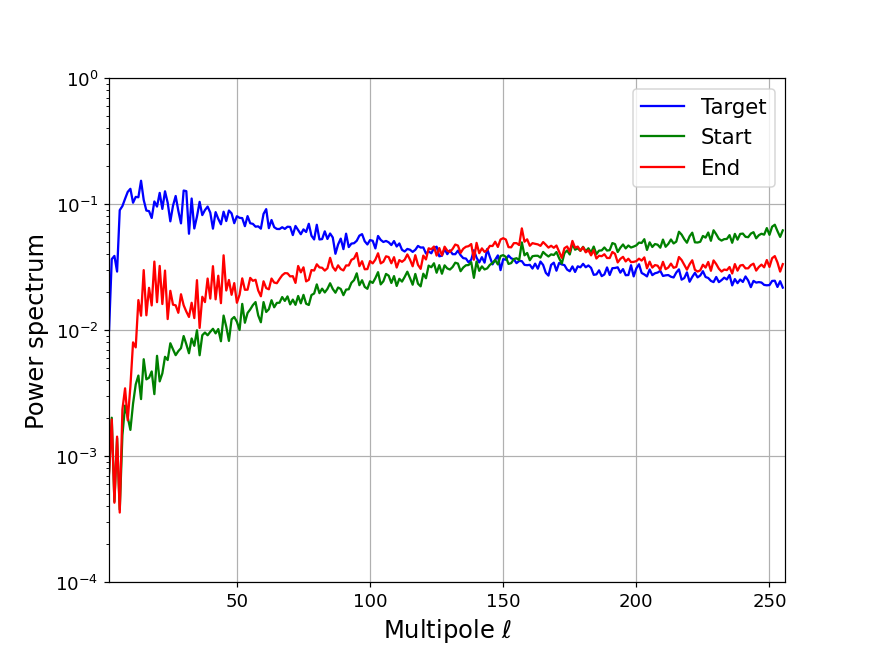

In [58]:
ps_target = sphlib.compute_ps(flm_target)
ps_start = sphlib.compute_ps(flm_start)
ps_end = sphlib.compute_ps(flm_end)

plt.figure(figsize=(8, 6))
plt.plot(ps_target, 'b', label="Target")
plt.plot(ps_start, 'g', label="Start")
plt.plot(ps_end, 'r', label="End")
plt.yscale("log")
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
plt.xlim(2, 256)
plt.ylim(1e-4, 1)
plt.legend()

In [59]:
print('Mean:', tmean, smean, emean)
print('Var:', tvar, svar, evar)

Mean: 0.016352476981190633 0.0028478717215003947 0.0027914828744580724
Var: 9.637311955554874e-05 5.96120692025783e-05 6.313779350513056e-05


<IPython.core.display.Javascript object>


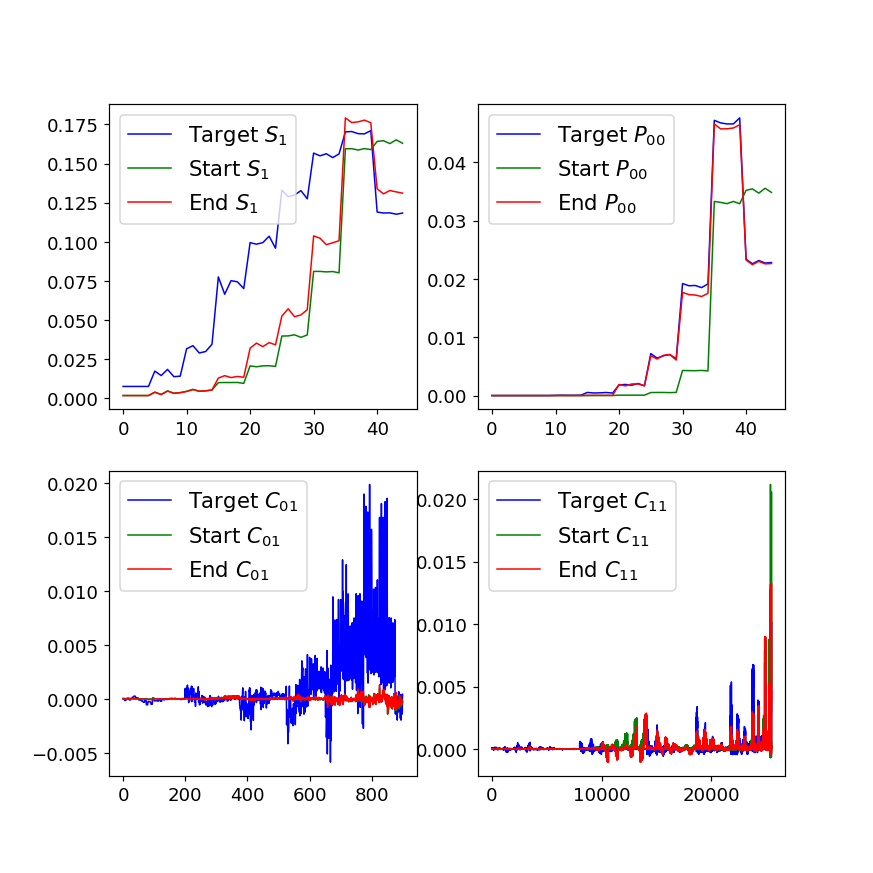

In [60]:
plot.plot_scatcov_coeffs(tS1, tP00, tC01, tC11, name='Target', hold=True, color='blue', lw=1)

plot.plot_scatcov_coeffs(sS1, sP00, sC01, sC11, name='Start', hold=False, color='green', lw=1)

plot.plot_scatcov_coeffs(eS1, eP00, eC01, eC11, name='End', hold=False, color='red', lw=1)